# CNN Cancer Detection Kaggle Mini-Project (Week 3 Peer-Graded Assignment)

## PROBLEM DESCRIPTION

This mini-project is part of a Kaggle competition, where the main goal is to identify metastatic cancer from a given collection of image datasets. The image datasets are a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, and they are taken from larger digital pathology scans.

Kaggle source: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

Contents for this project can be accessed in the following Github Repository:

Github Repository Link: https://github.com/IsraelsLibrary/DTSA_5511_CNN_Cancer_Detection_Kaggle_MiniProject

In [1]:
# Importing required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Helper function for cleaning the data labels and image datasets
def clean_data(table):
    table = table.any().dropna()
    if table.isnull().sum() > 0:
        clean_data(table)

In [3]:
# Reading in the training and test datasets

training_data_path = "data/train/"
test_data_path = "data/test/"

training_labels = "data/train_labels.csv"


# Check if the training labels exist before attempting to read the file
if os.path.exists(training_labels):
    # Open and read the file
    with open(training_labels, 'r') as file:
        labels_df = pd.read_csv(file)
        file.close()
else:
    print(f"The file {training_labels} does not exist in the specified folder.")
    
# Applying a helper function to clean the 'labels' dataframe
clean_data(labels_df)
    
    
# Filter the list to include only TIF training images
list_ = file_list = os.listdir(training_data_path)
tif_images = [file for file in list_ if file.lower().endswith('.tif')]

# Filter the list to include only TIF test images
test_list_ = file_list = os.listdir(test_data_path)
test_images = [file for file in test_list_ if file.lower().endswith('.tif')]

In [4]:
# Finding the percentage of data that is split between training and test sets, respectively.

print(f'Number of training images: {len(tif_images)}')
print(f'Number of test images: {len(test_images)}')


training_percent = len(tif_images) / (len(tif_images) + len(test_images))

testing_percent = len(test_images) / (len(tif_images) + len(test_images))



print(f'Percentage of training data that represents the collection: {round(training_percent * 100, 1)}%')
print(f'Percentage of testing data that represents the collection: {round(testing_percent * 100, 1)}%')


Number of training images: 220025
Number of test images: 57458
Percentage of training data that represents the collection: 79.3%
Percentage of testing data that represents the collection: 20.7%


## EXPLORATORY DATA ANALYSIS

Upon further observation, the images appear to be in a 'TIF' image format. In terms of quantity, there is a total of 220,025 training images and 57,458 test images from the collection, which leads to a split where the training data represents 79.3% of the whole collection and the testing data represents 20.7%. 

Data cleaning takes place in the form of a helper function, which cleans the data labels (that also involves removing missing entries or entries with null values). Further verification takes place to make sure that all of the input images have the same dimensions. For both training images and test images, the dimensions appear to be the same for each image, with a result of (96, 96, 3). Both training and test images are successfully transformed into multidimensional arrays in further preparation for the model analysis.

When looking at data visualizations for the data labels, the data visualizations reveal that 60% of the images contain no signs of cancer where the remaining 40% of images reveal the presence of cancer in those given images. 

As a result (and since we are dealing with a case of binary classification of images), I will be applying a convolutional neural network (CNN) model for this case and make any necessary optimizations so that the model can effectively detect cancer in selected images.


In [5]:
# Convert the training and test images into multidimensional arrays
def images_to_arrays(image_paths):
    return [np.array(Image.open(path).convert('RGB')) for path in image_paths]

# Assuming tif_images and test_images are your lists of image filenames
tif_arrays = images_to_arrays([os.path.join(training_data_path, image) for image in tif_images])
test_arrays = images_to_arrays([os.path.join(test_data_path, image) for image in test_images])

In [6]:
# Confirm that all multidimensional arrays have the same dimension
for array in tif_arrays:
    if array.shape!=(96, 96, 3):
        print(f'Different dimensions of {array.shape} for array {array}')

In [7]:
print(f'Dimensions for each training image: {tif_arrays[0].shape}')

print(f'Dimensions for each test image: {test_arrays[0].shape}')

Dimensions for each training image: (96, 96, 3)
Dimensions for each test image: (96, 96, 3)


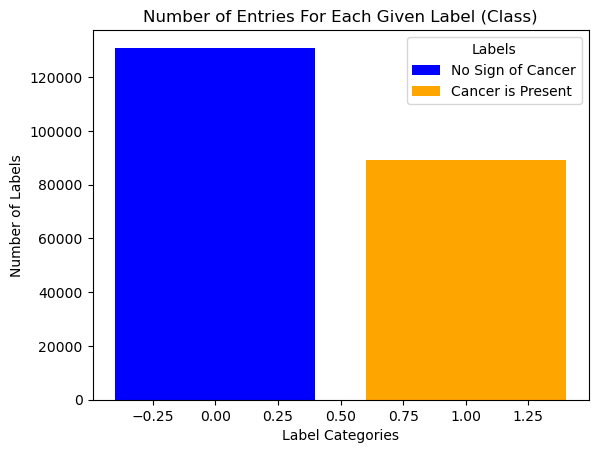

In [8]:
labels_df_plot = labels_df.groupby('label')['id'].count()

# Create a bar plot using Matplotlib directly
fig, ax = plt.subplots()
bars = ax.bar(labels_df_plot.index, labels_df_plot, color=['blue', 'orange'])

plt.xlabel('Label Categories')
plt.ylabel('Number of Labels')
plt.title('Number of Entries For Each Given Label (Class)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Adding legend using bars and labels
ax.legend(bars, ['No Sign of Cancer', 'Cancer is Present'], title='Labels')

plt.show()

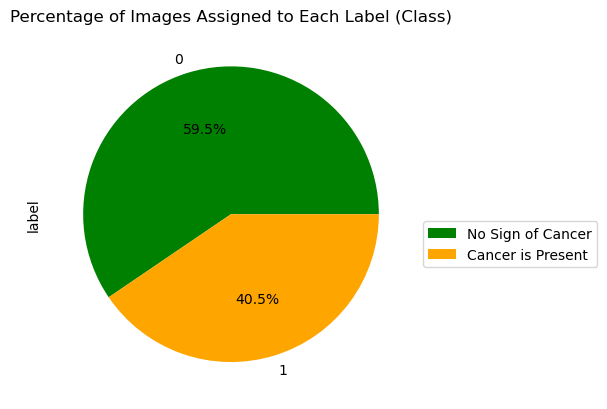

In [9]:
label_distribution = labels_df['label'].value_counts()
label_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange'])
plt.title('Percentage of Images Assigned to Each Label (Class)')

plt.legend(labels=['No Sign of Cancer', 'Cancer is Present'], loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()


## CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL AND ARCHITECTURE

For the architecture of the CNN model, I started with the basic structure and made sure the model included the following elements: an initial convolution layer, a max pooling layer for sub-sampling, and fully-connected layers (included a softmax layer) to handle the CNN output. The convolution and pooling layers are responsible for feature extraction for the input data, whereas the softmax layer and fully-connected layers acts as a classifier for the output layer. Before the fully-connected layers process the data, the data must be flattened after going through the convolution and pooling operations. Flattened data is necessary, because the fully-connected layers require a one-dimensional input.

In regards to development, I started creating a CNN model from scratch with the necessary components. For optimization purposes, I decided to go one step further and conduct a process of transfer learning, where I incorporated a base ResNet model as part of the architecture (more details on this can be seen in the next section). The initial code shown below includes the initial CNN architecture before incorporating the ResNet model.

In [10]:
# Convolutional Neural Network Model
             
class CNN():
    def __init__(self, input_shape, kernel, num_filters, filter_size, dropout, pooling_size, stride=None, padding=None):
        self.input_shape = input_shape
        self.kernel = kernel
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.pooling_size = pooling_size
        self.dropout = dropout
        
    def conv2D(self, image):
        flipped_kernel = self.kernel[::-1, ::-1]
    
        # Ensure that the image and kernel have compatible shapes
        if image.shape[0] < self.kernel.shape[0] or image.shape[1] < self.kernel.shape[1]:
            raise ValueError("Input image dimensions should be greater than or equal to kernel dimensions.")
    
        result_height = image.shape[0] - self.kernel.shape[0] + 1
        result_width = image.shape[1] - self.kernel.shape[1] + 1
    
        result_image = np.zeros((result_height, result_width))

        for i in range(result_height):
            for j in range(result_width):
                ROI = image[i:i + self.kernel.shape[0], j:j + self.kernel.shape[1]]
                result_image[i, j] = np.sum(np.multiply(ROI, flipped_kernel))

        return result_image
        
    def max_pooling2D(self, image):
        x_H, x_W = image.shape
        pool_H, pool_W = self.pooling_size
        
        updated_height = x_H // pool_H
        updated_weight = x_W // pool_W
        
        result_image = np.zeros((updated_height, updated_weight))
        
        for i in range(updated_height):
            for j in range(updated_weight):
                ROI = image[i * pool_H:(i + 1) * pool_H, j * pool_W:(j + 1) * pool_W]
                result_image[i, j] = np.max(ROI)

        return result_image
        
    def relu(self, x):
        return np.maximum(x, 0)
    
    def softmax(self, x):
        temp_values = np.exp(x - np.max(x))
        result = temp_values / temp_values.sum()
        return result
    
    def forward(self, x):
        x = self.relu(self.conv2D(x))
        x = self.max_pooling2D(x)
        x = x.flatten()

        softmax_result = self.softmax(x)
        return softmax_result

## CNN MODEL ARCHITECTURE, CONTINUED

However, for the CNN model developed from scratch, there were errors that occurred during the testing process, mainly due to data preparation and transformations. As an additional update, I decided to switch from a custom CNN model and relied more on the Keras library to implement the same functionality. In addition to these changes, I also included an option for transfer learning in the architecture, in case if I wanted to proceed and use a base model for the training process. As mentioned before, I ultimately went with the ResNet model as my base model implementation, due to past experience with the ResNet model and its effectiveness. This updated version appeared to work better, and the decision was made to follow this update and train the model. The updated code is displayed below.

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Define your CNN model
class CNN:
    def __init__(self, input_shape, base_model, dropout=0.5, num_classes=1):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dropout = dropout
        self.lr = 0.0001
        self.base_model = base_model
        self.model = models.Sequential()
        
    def set_learning_rate(self, lr):
        self.lr = lr
    
    def forward(self):
        self.model.add(layers.Input(shape=self.input_shape))

        if self.base_model is not None:
            self.model.add(self.base_model)
            self.model.add(layers.GlobalAveragePooling2D())
            
            
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Dense(128, activation='relu'))
            
            if self.dropout is not None:
                self.model.add(layers.Dropout(self.dropout))
                
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Dense(64, activation='relu'))
            
            if self.dropout is not None:
                self.model.add(layers.Dropout(self.dropout))

            self.model.add(layers.Dense(self.num_classes, activation='sigmoid'))
            
            for layer in self.base_model.layers[:-30]:
                layer.trainable = True
            
            self.model.add(layers.BatchNormalization())
            
            if self.dropout is not None:
                self.model.add(layers.Dropout(self.dropout))
        else:
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape))
            self.model.add(layers.MaxPooling2D((2,2)))
            
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Conv2D(32, (3,3), activation='relu'))
            self.model.add(layers.MaxPooling2D((2,2)))
            
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Conv2D(32, (3,3), activation='relu'))
            self.model.add(layers.MaxPooling2D((2,2)))
            
            self.model.add(layers.Flatten())
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Dense(128, activation='relu'))
            
            if self.dropout is not None:
                self.model.add(layers.Dropout(self.dropout))

            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=SGD(learning_rate=self.lr), loss='binary_crossentropy', metrics=['accuracy'])
        
        return self.model

## MODEL TRAINING, MODEL ANALYSIS, TUNING HYPERPARAMETERS, AND EVALUATION METRICS RESULTS

With the revised architecture, I applied different test cases to see how well the model would perform with different parameters. For the different test cases, I limit the size of the input data to 100 training images in order to limit training time and observe how different model architectures perform with a smaller amount of data. For initial testing purposes, I reduced the size of the input data to make sure the models work properly.

## TEST CASE 01: CNN MODEL ARCHITECTURE WITH RESNET50 BASE MODEL
This first test case implements a ResNet50 base model with the following parameters: number of epochs is 10, batch size is 32, and a learning rate value of 0.0001.

Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 6.7209 - accuracy: 0.5469 - val_loss: 0.7197 - val_accuracy: 0.5625
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 6.2082 - accuracy: 0.5688 - val_loss: 0.6924 - val_accuracy: 0.5625
Epoch 3/10
10/10 [==============================] - 19s 2s/step - loss: 5.8506 - accuracy: 0.5906 - val_loss: 0.6833 - val_accuracy: 0.5625
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 6.6077 - accuracy: 0.5469 - val_loss: 0.7429 - val_accuracy: 0.5750
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 6.1498 - accuracy: 0.5625 - val_loss: 0.9041 - val_accuracy: 0.6125
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 5.6292 - accuracy: 0.6000 - val_loss: 0.9081 - val_accuracy: 0.6375
Epoch 7/10
10/10 [==============================] - 19s 2s/step - loss: 6.3695 - accuracy: 0.5437 - val_loss: 0.9334 - val_accuracy: 0.6500
Epoch 8/10
3/3 [====

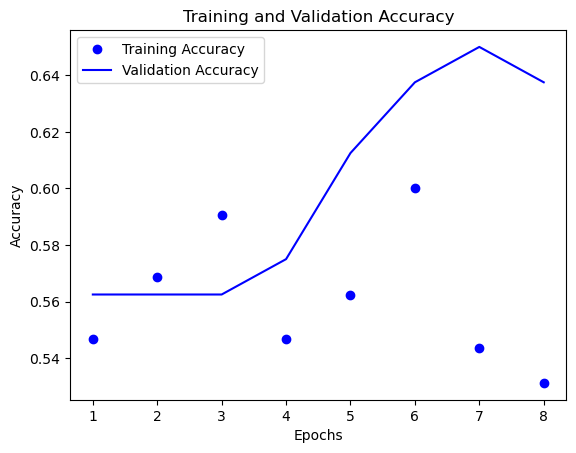

In [12]:
# Train the model using the training dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50


train_data = np.array(tif_arrays[:400])
labels = np.array(labels_df['label'][:400])
test_data = np.array(test_arrays[:400])

X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]


# Create and compile the model with ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create and compile CNN model with ResNet50 as the base model
cnn = CNN(input_shape, base_model=base_model)
model = cnn.forward()
#model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust the learning rate and implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evaluate your model on the validation set
validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)

# Evaluate your model on the separate test set
test_accuracy = model.evaluate(test_data, labels)
print("Test Accuracy:", test_accuracy)

# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()


## TEST CASE 02: CNN MODEL ARCHITECTURE WITH RESNET50 BASE MODEL
Results from the first case did not yield highly accurate results. Validation loss appears to fluctuate, and the training and validation accuracies don't match up (even though they seem to have the same behavior). I experiment further with the next series of test cases. This second test case implements a ResNet50 base model with the following parameters: number of epochs is 10, batch size is 16, and a learning rate value of 0.0001. I also apply data augmentation to further transform the input data.

Epoch 1/10
20/20 [==============================] - 18s 785ms/step - loss: 6.5496 - accuracy: 0.5531 - val_loss: 1.8946 - val_accuracy: 0.6125
Epoch 2/10
20/20 [==============================] - 18s 917ms/step - loss: 6.4542 - accuracy: 0.5531 - val_loss: 2.1551 - val_accuracy: 0.6250
Epoch 3/10
20/20 [==============================] - 19s 937ms/step - loss: 6.6497 - accuracy: 0.5344 - val_loss: 1.9922 - val_accuracy: 0.6000
Epoch 4/10
20/20 [==============================] - 19s 929ms/step - loss: 6.2329 - accuracy: 0.5469 - val_loss: 1.9593 - val_accuracy: 0.6000
Epoch 5/10
20/20 [==============================] - 28s 1s/step - loss: 6.0563 - accuracy: 0.5750 - val_loss: 1.9838 - val_accuracy: 0.5750
Epoch 6/10
20/20 [==============================] - 24s 1s/step - loss: 5.9904 - accuracy: 0.5781 - val_loss: 1.8535 - val_accuracy: 0.5750
Epoch 7/10
20/20 [==============================] - 22s 1s/step - loss: 6.2322 - accuracy: 0.5688 - val_loss: 2.1840 - val_accuracy: 0.6125
Epoch 8/

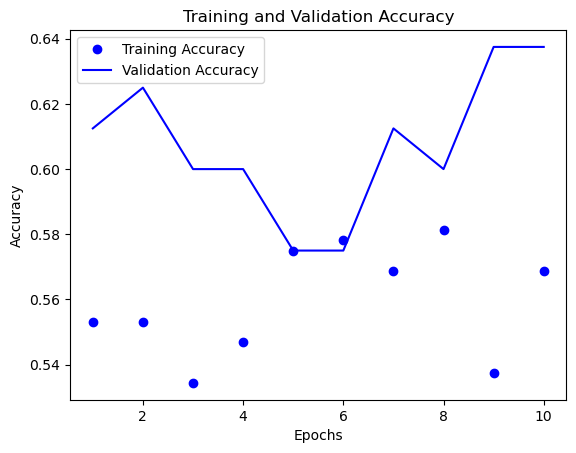

In [13]:
# Use data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = np.array(tif_arrays[:400])
labels = np.array(labels_df['label'][:400])
test_data = np.array(test_arrays[:400])

X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]


# Create and compile the model with ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create and compile CNN model with ResNet50 as the base model
cnn = CNN(input_shape, base_model=base_model)
model = cnn.forward()
#model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust the learning rate and implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=16), epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evaluate your model on the validation set
validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)

# Evaluate your model on the separate test set
test_accuracy = model.evaluate(test_data, labels)
print("Test Accuracy:", test_accuracy)


# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()


## TEST CASE 03: CNN MODEL ARCHITECTURE WITH RESNET50 BASE MODEL
This third test case implements a ResNet50 base model with the following parameters: number of epochs is 10, batch size is 32, and a learning rate value of 0.01.

Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 6.3985 - accuracy: 0.5469 - val_loss: 2.0227 - val_accuracy: 0.3750
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 6.5333 - accuracy: 0.5437 - val_loss: 4.1056 - val_accuracy: 0.6250
Epoch 3/10
10/10 [==============================] - 19s 2s/step - loss: 6.5981 - accuracy: 0.5250 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 4/10
10/10 [==============================] - 30s 3s/step - loss: 6.7117 - accuracy: 0.5437 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 5/10
10/10 [==============================] - 24s 2s/step - loss: 7.2804 - accuracy: 0.5063 - val_loss: 9.5308 - val_accuracy: 0.3750
Epoch 6/10
3/3 [==============================] - 2s 463ms/step - loss: 2.0227 - accuracy: 0.3750
Validation Accuracy: [2.0227131843566895, 0.375]
13/13 [==============================] - 9s 730ms/step - loss: 1.8959 - accuracy: 0.4150
Test Accuracy: [1.8958954811096191, 0.41499999165534973]


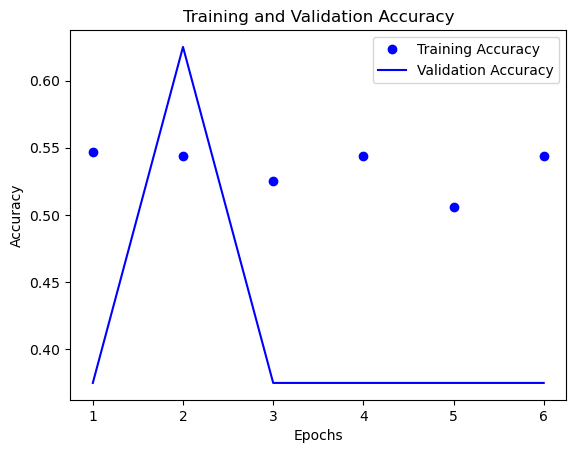

In [14]:
# Use data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = np.array(tif_arrays[:400])
labels = np.array(labels_df['label'][:400])
test_data = np.array(test_arrays[:400])

X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]


# Create and compile the model with ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create and compile CNN model with ResNet50 as the base model
cnn = CNN(input_shape, base_model=base_model)
cnn.set_learning_rate(0.01)
model = cnn.forward()
#model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust the learning rate and implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evaluate your model on the validation set
validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)

# Evaluate your model on the separate test set
test_accuracy = model.evaluate(test_data, labels)
print("Test Accuracy:", test_accuracy)


# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()


## TEST CASE 04: CNN MODEL ARCHITECTURE WITH RESNET50 BASE MODEL
This fourth test case implements a ResNet50 base model with the following parameters: number of epochs is 20, batch size is 32, and a learning rate value of 0.0001.

Epoch 1/20
10/10 [==============================] - 28s 3s/step - loss: 6.2095 - accuracy: 0.5469 - val_loss: 0.8300 - val_accuracy: 0.5125
Epoch 2/20
10/10 [==============================] - 25s 2s/step - loss: 6.4197 - accuracy: 0.5437 - val_loss: 0.8218 - val_accuracy: 0.4875
Epoch 3/20
10/10 [==============================] - 19s 2s/step - loss: 6.1350 - accuracy: 0.5656 - val_loss: 0.8343 - val_accuracy: 0.5375
Epoch 4/20
10/10 [==============================] - 21s 2s/step - loss: 6.4958 - accuracy: 0.5500 - val_loss: 1.1614 - val_accuracy: 0.5750
Epoch 5/20
10/10 [==============================] - 21s 2s/step - loss: 6.8213 - accuracy: 0.5344 - val_loss: 1.1505 - val_accuracy: 0.5750
Epoch 6/20
10/10 [==============================] - 18s 2s/step - loss: 6.4795 - accuracy: 0.5469 - val_loss: 1.1742 - val_accuracy: 0.5375
Epoch 7/20
3/3 [==============================] - 1s 417ms/step - loss: 0.8218 - accuracy: 0.4875
Validation Accuracy: [0.8217576742172241, 0.48750001192092896]

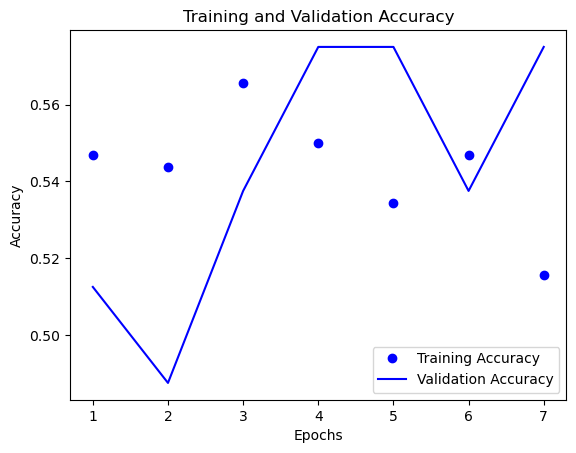

In [15]:
# Train the model using the training dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50

# Use data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = np.array(tif_arrays[:400])
labels = np.array(labels_df['label'][:400])
test_data = np.array(test_arrays[:400])

X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]


# Create and compile the model with ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create and compile CNN model with ResNet50 as the base model
cnn = CNN(input_shape, base_model=base_model)
cnn.set_learning_rate(0.0001)
model = cnn.forward()
#model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust the learning rate and implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evaluate your model on the validation set
validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)

# Evaluate your model on the separate test set
test_accuracy = model.evaluate(test_data, labels)
print("Test Accuracy:", test_accuracy)

# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()



## TEST CASE 05: CNN MODEL ARCHITECTURE WITH RESNET50 BASE MODEL
For these last two cases, I decided to increase the size of the input data and changed the data augmentation parameters (to see how well the model will perform with expanded data). This fifth test case implements a ResNet50 base model with the following parameters: number of epochs is 20, batch size is 16, and a learning rate value of 0.00001. The main difference between this model and the last model is that the last model implements a VGG16 base model (for comparison purposes) and the data augmentation parameters remain unchanged.

Epoch 1/20
2873/2873 [==============================] - 2941s 1s/step - loss: 6.3411 - accuracy: 0.5873 - val_loss: 2.7828 - val_accuracy: 0.5875
Epoch 2/20
2873/2873 [==============================] - 2368s 824ms/step - loss: 6.3448 - accuracy: 0.5871 - val_loss: 2.1682 - val_accuracy: 0.5858
Epoch 3/20
2873/2873 [==============================] - 1027s 357ms/step - loss: 6.3426 - accuracy: 0.5871 - val_loss: 2.6238 - val_accuracy: 0.5873
Epoch 4/20
2873/2873 [==============================] - 1001s 348ms/step - loss: 6.3172 - accuracy: 0.5888 - val_loss: 2.5602 - val_accuracy: 0.5873
Epoch 5/20
2873/2873 [==============================] - 1011s 352ms/step - loss: 6.3433 - accuracy: 0.5870 - val_loss: 2.2215 - val_accuracy: 0.5861
Epoch 6/20
2873/2873 [==============================] - 1008s 351ms/step - loss: 6.3225 - accuracy: 0.5882 - val_loss: 2.3932 - val_accuracy: 0.5860
Epoch 7/20
2873/2873 [==============================] - 990s 345ms/step - loss: 6.3262 - accuracy: 0.5883 - v

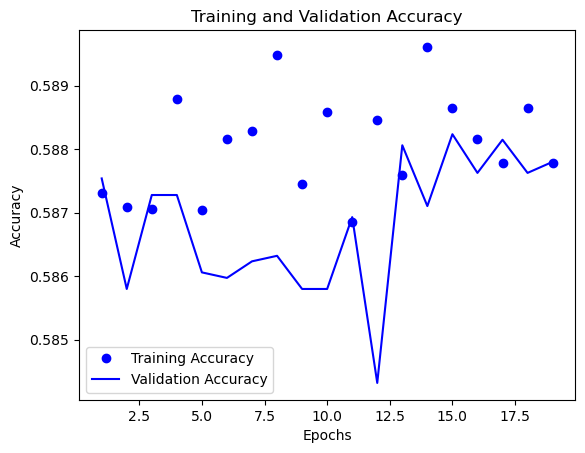

In [16]:
# Train the model using the training dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50

# Use data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = np.array(tif_arrays[:57458])
labels = np.array(labels_df['label'][:57458])
test_data = np.array(test_arrays[:57458])


X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]


# Create and compile the model with ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create and compile CNN model with ResNet50 as the base model
cnn = CNN(input_shape, base_model=base_model, dropout=0.9)
cnn.set_learning_rate(0.00001)
best_model = cnn.forward()

# Adjust the learning rate and implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = best_model.fit(data_augmentation.flow(X_train, y_train, batch_size=16), epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate your model on the validation set
validation_accuracy = best_model.evaluate(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)

# Evaluate your model on the separate test set
test_accuracy = best_model.evaluate(test_data, labels)
print("Test Accuracy:", test_accuracy)

# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()



## TEST CASE 06: CNN MODEL ARCHITECTURE WITH VGG16 BASE MODEL
This last test case implements a VGG16 base model with the following parameters: number of epochs is 20, batch size is 16, and a learning rate value of 0.00001.

Epoch 1/20
2873/2873 [==============================] - 1267s 440ms/step - loss: 6.3103 - accuracy: 0.5560 - val_loss: 5.0104 - val_accuracy: 0.5710
Epoch 2/20
2873/2873 [==============================] - 998s 347ms/step - loss: 6.3245 - accuracy: 0.5555 - val_loss: 2.1496 - val_accuracy: 0.4997
Epoch 3/20
2873/2873 [==============================] - 988s 344ms/step - loss: 6.2431 - accuracy: 0.5575 - val_loss: 4.5954 - val_accuracy: 0.5502
Epoch 4/20
2873/2873 [==============================] - 993s 346ms/step - loss: 6.0193 - accuracy: 0.5612 - val_loss: 4.4505 - val_accuracy: 0.5881
Epoch 5/20
2873/2873 [==============================] - 1013s 352ms/step - loss: 5.0863 - accuracy: 0.5726 - val_loss: 3.5647 - val_accuracy: 0.5881
Epoch 6/20
2873/2873 [==============================] - 997s 347ms/step - loss: 4.4708 - accuracy: 0.5629 - val_loss: 0.8120 - val_accuracy: 0.5881
Epoch 7/20
2873/2873 [==============================] - 1027s 358ms/step - loss: 3.4595 - accuracy: 0.5866 - v

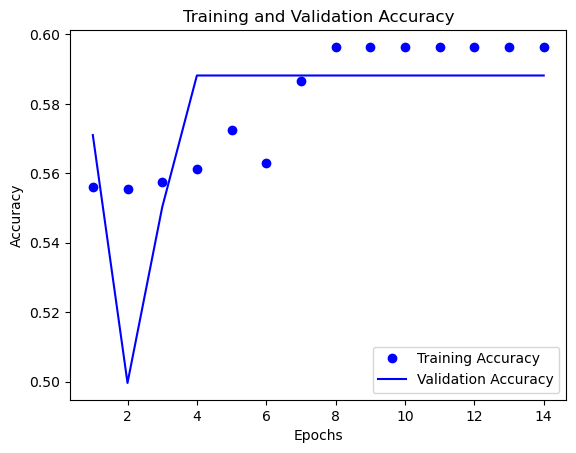

In [18]:
# Train the model using the training dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

# Use data augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = np.array(tif_arrays[:57458])
labels = np.array(labels_df['label'][:57458])
test_data = np.array(test_arrays[:57458])

X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]


# Create and compile the model with ResNet50 as the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freezing the layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create and compile CNN model with ResNet50 as the base model
cnn = CNN(input_shape, base_model=base_model, dropout=0.8)
cnn.set_learning_rate(0.00001)
vgg_model = cnn.forward()
#model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Adjust the learning rate and implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=16), epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evaluate your model on the validation set
validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)

# Evaluate your model on the separate test set
test_accuracy = model.evaluate(test_data, labels)
print("Test Accuracy:", test_accuracy)

# Extracting accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating epochs range for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()



## MODEL TEST RESULTS FOR KAGGLE COMPETITION SUBMISSION

The following code generates an output submission CSV file for the Kaggle competition, based on the results of the best performing model (the ResNet-based model with 20 epochs).

In [17]:
ids_ = []

for i in test_list_:
    j = i.replace('.tif', '')
    ids_.append(j)
    

predicted_probs = best_model.predict(test_data)

predicted_labels = []


for prediction in predicted_probs:
    if prediction > 0.5:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

data = {'id': ids_, 'label': predicted_labels}

df = pd.DataFrame(data)

df.to_csv('Final_Submission_File.csv', index=False)

57458
1796/1796 [==============================] - 808s 450ms/step


## EVALUATION RESULTS

While training the models, I noticed that an additional issue of overfitting beginning to occur with each test run. Increasing the dropout value and reducing the batch size seemed to resolve this matter to a degree and helped to slightly improve the model. I also increased the size of the input data to observe more data points during the training process, as well as switched to a base model of VGG16. In summary, the ResNet-based model seemed to perform better at higher epochs with the batch size reduced to 16. Yes, both models resulted with similar test accuracies, but overfitting seemed to occur again for the VGG16 model as the number of epochs increased.

## DISCUSSION, LESSONS LEARNED, AND CONCLUSION

As a result of the model training process, the best model appears to be the CNN model with the following conditions: 

1.) an implemented ResNet50 base model <br>
2.) an increased size of input data <br>
3.) number of epochs set to 20 <br>
4.) a decreased learning rate value of 0.00001 <br>
5.) decreased batch size of 16 <br>

As tne number of epochs increase and further training takes place, the model seems to perform slightly better  than previous test runs with a smaller batch size. In other cases that involved the ResNet50 model, the plots reveal a great degree of overfitting, which can be problematic when testing with higher volumes of data. And even though the CNN model with a VGG16 base model performed about the same as the last ResNet model, the nature of this performance can change with a larger volume of data, especially since VGG16 models are meant to be more effective with smaller datasets. However, the ResNet50 base model proves to show consistent performance (with potential improvement) as the number of epochs increase from 10 to 20. Lastly, as mentioned before in this class, the learning rate has an impact here too. The models appears to perform better as the learning rate value decreases. This is shown when the ResNet50-based model is tested with an increase epoch value of 20.

In conclusion, the ResNet50 model proves to be an effective base model when applied to a given CNN model. With additional time and more exploration, we can optimize the hyperparameters even further so that the model achieves a higher accuracy. At the very least, if other AI/ML researchers choose to apply transfer learning for this use case of cancer detection, this project shows that the ResNet50 base model would be a good starting point for further analysis.